# H-1B Visa Petition
## 05:Classical Model Tuning
**Author:** Prasoon Karmacharya

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.metrics import (accuracy_score, confusion_matrix, plot_confusion_matrix,
                             ConfusionMatrixDisplay, classification_report, 
                             f1_score, recall_score, precision_score, 
                             roc_curve, roc_auc_score, hamming_loss, jaccard_score)
from sklearn.pipeline import Pipeline

RANDOM_STATE = 42


from imblearn.datasets import make_imbalance
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Read Data

In [3]:
data = pd.read_pickle("../assets/data/cleaned_h1b.pkl")

In [4]:
data.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,YEAR_coded,SOC_NAME_coded
0,1,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,0,36067.0,2016.0,"ANN ARBOR, MICHIGAN",5,192
1,1,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,1,242674.0,2016.0,"PLANO, TEXAS",5,297
2,1,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,1,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",5,297
3,1,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",1,220314.0,2016.0,"DENVER, COLORADO",5,297
5,1,BURGER KING CORPORATION,CHIEF EXECUTIVES,"EXECUTIVE V P, GLOBAL DEVELOPMENT AND PRESIDEN...",1,225000.0,2016.0,"MIAMI, FLORIDA",5,297


In [5]:
feature_cols = ['FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR_coded', 'SOC_NAME_coded']
target_col = ['CASE_STATUS']

* Split the data into dev, validation, and test set 60:10:10

In [6]:
# dev, test = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)
dev, test = train_test_split(data, test_size=0.15, random_state=RANDOM_STATE)

In [7]:
train, val = train_test_split(dev, test_size=0.15, random_state=RANDOM_STATE)

In [8]:
train.shape[0]/data.shape[0]

0.7224995916862134

In [9]:
val.shape[0]/data.shape[0]

0.1275002529301046

In [10]:
test.shape[0]/data.shape[0]

0.15000015538368203

In [11]:
X_train = train[feature_cols]
y_train = train[target_col]

X_val = val[feature_cols]
y_val = val[target_col]

X_test = test[feature_cols]
y_test = test[target_col]

In [12]:
y_train["CASE_STATUS"].value_counts(normalize=True)

1    0.967274
0    0.032726
Name: CASE_STATUS, dtype: float64

In [13]:
y_train["CASE_STATUS"].value_counts()

1    2023925
0      68475
Name: CASE_STATUS, dtype: int64

In [14]:
68475*(.75/.25)

205425.0

In [15]:
sampling_strategy = {0:68475, 1:205425}
X_train_balanced, y_train_balanced = make_imbalance(X_train, 
                                                    y_train, 
                                                    sampling_strategy=sampling_strategy, 
                                                    random_state=RANDOM_STATE)

In [16]:
y_train_balanced["CASE_STATUS"].value_counts(normalize=True)

1    0.75
0    0.25
Name: CASE_STATUS, dtype: float64

In [17]:
def evaluate_model(clf, clf_name, X_train, y_train, X_val, y_val, X_test, y_test, y_pred_val, y_pred_test):
    print("-----------------------------------------------")

    model_results = {}
    
#     model_results['Classifier'] = clf.__class__.__name__
    model_results['Classifier'] = clf_name
    
    
    model_results['Best Parameters'] = clf.best_params_
    
    model_results['Accuracy (train)'] = clf.score(X_train, y_train)
    
    # Validation Performance
    model_results['Accuracy (val)'] = clf.score(X_val, y_val)
    model_results['Accuracy (test)'] = clf.score(X_test, y_test)
    
    model_results['Recall (val)'] = recall_score(y_val, y_pred_val, average='weighted', labels=np.unique(y_pred_val))
    model_results['Precision (val)'] = precision_score(y_val, y_pred_val, average='weighted', labels=np.unique(y_pred_val))
    model_results['F1-score (val)'] = f1_score(y_val, y_pred_val, average='weighted', labels=np.unique(y_pred_val))
    model_results['AUC-ROC (val)'] = roc_auc_score(y_val, y_pred_val)
    model_results['Jacard score (val)'] = jaccard_score(y_val, y_pred_val,average='weighted', labels=np.unique(y_pred_test))
    model_results['Hamming Loss (val)'] = hamming_loss(y_val, y_pred_val)
    
    model_results['CV Accuracy'] = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    # Test Performance
    model_results['Recall (test)'] = recall_score(y_test, y_pred_test, average='weighted', labels=np.unique(y_pred_test))
    model_results['Precision (test)'] = precision_score(y_test, y_pred_test, average='weighted', labels=np.unique(y_pred_test))
    model_results['F1-score (test)'] = f1_score(y_test, y_pred_test, average='weighted', labels=np.unique(y_pred_test))
    model_results['AUC-ROC (test)'] = roc_auc_score(y_test, y_pred_test)
    model_results['Jacard score (test)'] = jaccard_score(y_test, y_pred_test, average='weighted', labels=np.unique(y_pred_test))
    model_results['Hamming Loss (test)'] = hamming_loss(y_test, y_pred_test)   
    
    return model_results

## Model Tunning one at a time

In [18]:
eval_cols = ['Classifier', 'Best Parameters', 
             'F1-score (val)', 'F1-score (test)',
             'Recall (val)', 'Recall (test)', 
             'Precision (val)', 'Precision (test)', 
             'AUC-ROC (val)', 'AUC-ROC (test)']

In [19]:
def best_model_info(model_benchmark_df, evaluation_metric = 'F1-score (test)'):
    best_model_index = model_benchmark_df[model_benchmark_df[evaluation_metric]== model_benchmark_df[evaluation_metric].max()].index.values
    best_params = model_benchmark_df[model_benchmark_df.index == best_model_index[0]]["Best Parameters"].values
    best_scores = model_benchmark_df[model_benchmark_df.index == best_model_index[0]][eval_cols]
    return best_scores, best_params

### Model 1: Logistic Regression

In [20]:
logistic_reg_model_benchmark_file_path = "../assets/model_performance/01_logistic_regression_model_performance.csv"
if Path("../assets/model_performance/01_logistic_regression_model_performance.csv").is_file():
    model_benchmark_log_reg = pd.read_csv(logistic_reg_model_benchmark_file_path)
else:
    model_benchmark_log_reg = pd.DataFrame(columns=['Classifier', 'Best Parameters', 'Accuracy (train)', 'Accuracy (val)', 'Accuracy (test)', 'CV Accuracy', 
                                    'Recall (val)', 'Precision (val)', 'F1-score (val)', 'AUC-ROC (val)', 'Jacard score (val)', 'Hamming Loss (val)',
                                    'Recall (test)', 'Precision (test)', 'F1-score (test)', 'AUC-ROC (test)', 'Jacard score (test)', 'Hamming Loss (test)'
                                   ])

In [21]:
model_benchmark_log_reg

,Classifier,Best Parameters,Accuracy (train),Accuracy (val),Accuracy (test),CV Accuracy,Recall (val),Precision (val),F1-score (val),AUC-ROC (val),Jacard score (val),Hamming Loss (val),Recall (test),Precision (test),F1-score (test),AUC-ROC (test),Jacard score (test),Hamming Loss (test)
0,Logistic Regression,"{'C': 0.0001, 'penalty': 'l2'}",0.859083,0.983884,0.983936,0.859082,0.968298,0.968145,0.953274,0.508848,0.937622,0.031702,0.968396,0.968465,0.953378,0.508269,0.937807,0.031604
1,Logistic Regression,"{'C': 1e-05, 'penalty': 'l2'}",0.859083,0.983884,0.983936,0.859082,0.968298,0.968145,0.953274,0.508848,0.937622,0.031702,0.968396,0.968465,0.953378,0.508269,0.937807,0.031604
2,Logistic Regression,"{'C': 1e-05, 'penalty': 'none'}",0.859083,0.983884,0.983936,0.859082,0.968298,0.968145,0.953274,0.508848,0.937622,0.031702,0.968396,0.968465,0.953378,0.508269,0.937807,0.031604
3,Logistic Regression,"{'C': 1e-05, 'class_weight': 'none', 'penalty'...",0.859083,0.983884,0.983936,0.859082,0.968298,0.968145,0.953274,0.508848,0.937622,0.031702,0.968396,0.968465,0.953378,0.508269,0.937807,0.031604
4,Logistic Regression,"{'C': 1e-05, 'class_weight': 'balanced', 'pena...",0.000000,0.000000,0.000000,0.000000,1.000000,0.032252,0.062489,0.500000,0.032252,0.967748,1.000000,0.032120,0.062240,0.500000,0.032120,0.967880
5,Logistic Regression,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.861858,0.980864,0.981059,0.861751,0.962529,0.945757,0.952617,0.530259,0.933194,0.037471,0.962904,0.946179,0.952951,0.530515,0.933693,0.037096
6,Logistic Regression,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.861506,0.982170,0.982190,0.861474,0.965029,0.947314,0.953521,0.525747,0.935432,0.034971,0.965065,0.947191,0.953564,0.524841,0.935538,0.034935
7,Logistic Regression,"{'C': 0.003, 'penalty': 'l1', 'solver': 'libli...",0.861568,0.981988,0.982029,0.861613,0.964680,0.947023,0.953415,0.526541,0.935130,0.035320,0.964757,0.947043,0.953515,0.525999,0.935296,0.035243


In [22]:
%%capture
# parameters for Gridsearch

lr_params = {
    'penalty' : ['l1', 'l2'],
    'C': np.linspace(0.0001,0.003,5),
    'solver': ['liblinear', 'saga' ]    
}

lr_params_best = {
    'penalty' : ['l2'],
    'C': [0.001],
    'solver': ['liblinear']    
}

lr = LogisticRegression()

# lr_GS = GridSearchCV(lr, lr_params, scoring='f1', cv=5, verbose=True, n_jobs=-1)
lr_GS = GridSearchCV(lr, lr_params_best, scoring='f1', cv=5, verbose=True, n_jobs=-1)


lr_GS.fit(X_train_balanced, y_train_balanced)

y_pred_val = lr_GS.predict(X_val)
y_pred_test = lr_GS.predict(X_test)


# Add to the history
evaluation_result = evaluate_model(clf=lr_GS,
                                   clf_name = "Logistic Regression",
                                   X_train = X_train_balanced, 
                                   y_train = y_train_balanced,
                                   X_val = X_val,
                                   y_val = y_val,
                                   X_test = X_test, 
                                   y_test = y_test,
                                   y_pred_val = y_pred_val, 
                                   y_pred_test = y_pred_test)




In [23]:
model_benchmark_log_reg = model_benchmark_log_reg.append(evaluation_result, ignore_index=True)


In [24]:
LR_best_scores, LR_best_params = best_model_info(model_benchmark_log_reg)
LR_best_scores

,Classifier,Best Parameters,F1-score (val),F1-score (test),Recall (val),Recall (test),Precision (val),Precision (test),AUC-ROC (val),AUC-ROC (test)
6,Logistic Regression,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.953521,0.953564,0.965029,0.965065,0.947314,0.947191,0.525747,0.524841


In [25]:
LR_best_params

array(["{'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}"],
      dtype=object)

In [26]:
model_benchmark_log_reg[eval_cols]

,Classifier,Best Parameters,F1-score (val),F1-score (test),Recall (val),Recall (test),Precision (val),Precision (test),AUC-ROC (val),AUC-ROC (test)
0,Logistic Regression,"{'C': 0.0001, 'penalty': 'l2'}",0.953274,0.953378,0.968298,0.968396,0.968145,0.968465,0.508848,0.508269
1,Logistic Regression,"{'C': 1e-05, 'penalty': 'l2'}",0.953274,0.953378,0.968298,0.968396,0.968145,0.968465,0.508848,0.508269
2,Logistic Regression,"{'C': 1e-05, 'penalty': 'none'}",0.953274,0.953378,0.968298,0.968396,0.968145,0.968465,0.508848,0.508269
3,Logistic Regression,"{'C': 1e-05, 'class_weight': 'none', 'penalty'...",0.953274,0.953378,0.968298,0.968396,0.968145,0.968465,0.508848,0.508269
4,Logistic Regression,"{'C': 1e-05, 'class_weight': 'balanced', 'pena...",0.062489,0.062240,1.000000,1.000000,0.032252,0.032120,0.500000,0.500000
5,Logistic Regression,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.952617,0.952951,0.962529,0.962904,0.945757,0.946179,0.530259,0.530515
6,Logistic Regression,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.953521,0.953564,0.965029,0.965065,0.947314,0.947191,0.525747,0.524841
7,Logistic Regression,"{'C': 0.003, 'penalty': 'l1', 'solver': 'libli...",0.953415,0.953515,0.964680,0.964757,0.947023,0.947043,0.526541,0.525999
8,Logistic Regression,"{'C': 0.001, 'penalty': 'l2', 'solver': 'libli...",0.953274,0.953378,0.968298,0.968396,0.968145,0.968465,0.508848,0.508269


In [27]:
model_benchmark_log_reg.to_csv("../assets/model_performance/01_logistic_regression_model_performance.csv", index=False)

### Model 2: Linear SVC

In [28]:
linear_SVC_model_benchmark_file_path = "../assets/model_performance/02_linear_SVC_model_performance.csv"
if Path("../assets/model_performance/02_linear_SVC_model_performance.csv").is_file():
    model_benchmark_SVC = pd.read_csv(linear_SVC_model_benchmark_file_path)
else:
    model_benchmark_SVC = pd.DataFrame(columns=['Classifier', 'Best Parameters', 'Accuracy (train)', 'Accuracy (val)', 'Accuracy (test)', 'CV Accuracy', 
                                    'Recall (val)', 'Precision (val)', 'F1-score (val)', 'AUC-ROC (val)', 'Jacard score (val)', 'Hamming Loss (val)',
                                    'Recall (test)', 'Precision (test)', 'F1-score (test)', 'AUC-ROC (test)', 'Jacard score (test)', 'Hamming Loss (test)'
                                   ])

In [29]:
model_benchmark_SVC

,Classifier,Best Parameters,Accuracy (train),Accuracy (val),Accuracy (test),CV Accuracy,Recall (val),Precision (val),F1-score (val),AUC-ROC (val),Jacard score (val),Hamming Loss (val),Recall (test),Precision (test),F1-score (test),AUC-ROC (test),Jacard score (test),Hamming Loss (test)
0,SVC,"{'C': 0.00025075000000000005, 'loss': 'hinge',...",0.857699,0.982235,0.982307,0.342999,0.965107,0.941325,0.951451,0.506104,0.934418,0.034893,0.965245,0.941252,0.951577,0.505498,0.934642,0.034755
1,SVC,"{'C': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}",0.857746,0.982393,0.982452,0.171436,0.965411,0.941439,0.951545,0.505692,0.934683,0.034589,0.965523,0.941234,0.951642,0.504949,0.934875,0.034477
2,SVC,"{'SVC__C': 0.0001, 'SVC__loss': 'hinge', 'SVC_...",0.859046,0.983879,0.983931,0.859040,0.968287,0.968250,0.953243,0.508639,0.937598,0.031713,0.968387,0.968699,0.953347,0.508057,0.937785,0.031613


In [30]:
%%capture
# pipeline 

SVC_pipeline = Pipeline([
#     ('ss', StandardScaler()),
    ('SVC', LinearSVC(random_state=RANDOM_STATE, tol=1e-05))
])

# parameters for Gridsearch
SVC_params = {
    'SVC__penalty' : ['l2'],
    'SVC__C': np.linspace(0.000001,0.0001,3),
    'SVC__loss': ['hinge']
}

SVC_params_best = {
    'SVC__penalty' : ['l2'],
    'SVC__C': [0.0001],
    'SVC__loss': ['hinge']
}

# SVC_GS = GridSearchCV(SVC_pipeline, SVC_params, scoring='f1', cv=5, verbose=True, n_jobs=-1)
SVC_GS = GridSearchCV(SVC_pipeline, SVC_params_best, scoring='f1', cv=5, verbose=True, n_jobs=-1)


SVC_GS.fit(X_train_balanced, y_train_balanced)

y_pred_val = SVC_GS.predict(X_val)
y_pred_test = SVC_GS.predict(X_test)


# Add to the history
evaluation_result = evaluate_model(clf=SVC_GS, 
                                   clf_name = "SVC",
                                   X_train = X_train_balanced, 
                                   y_train = y_train_balanced,
                                   X_val = X_val,
                                   y_val = y_val,
                                   X_test = X_test, 
                                   y_test = y_test,
                                   y_pred_val = y_pred_val, 
                                   y_pred_test = y_pred_test)

In [33]:
model_benchmark_SVC = model_benchmark_SVC.append(evaluation_result, ignore_index=True)


In [34]:
model_benchmark_SVC[eval_cols]

,Classifier,Best Parameters,F1-score (val),F1-score (test),Recall (val),Recall (test),Precision (val),Precision (test),AUC-ROC (val),AUC-ROC (test)
0,SVC,"{'C': 0.00025075000000000005, 'loss': 'hinge',...",0.951451,0.951577,0.965107,0.965245,0.941325,0.941252,0.506104,0.505498
1,SVC,"{'C': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}",0.951545,0.951642,0.965411,0.965523,0.941439,0.941234,0.505692,0.504949
2,SVC,"{'SVC__C': 0.0001, 'SVC__loss': 'hinge', 'SVC_...",0.953243,0.953347,0.968287,0.968387,0.968250,0.968699,0.508639,0.508057
3,SVC,"{'SVC__C': 0.0001, 'SVC__loss': 'hinge', 'SVC_...",0.951932,0.952087,0.967753,0.967853,0.954986,0.943224,0.500327,0.500124
4,SVC,"{'SVC__C': 0.0001, 'SVC__loss': 'hinge', 'SVC_...",0.951932,0.952087,0.967753,0.967853,0.954986,0.943224,0.500327,0.500124


In [35]:
SVC_GS.best_params_

{'SVC__C': 0.0001, 'SVC__loss': 'hinge', 'SVC__penalty': 'l2'}

In [36]:
model_benchmark_SVC.to_csv("../assets/model_performance/02_linear_SVC_model_performance.csv", index=False)

In [37]:
SVC_best_scores, SVC_best_params = best_model_info(model_benchmark_SVC)
SVC_best_scores 

,Classifier,Best Parameters,F1-score (val),F1-score (test),Recall (val),Recall (test),Precision (val),Precision (test),AUC-ROC (val),AUC-ROC (test)
2,SVC,"{'SVC__C': 0.0001, 'SVC__loss': 'hinge', 'SVC_...",0.953243,0.953347,0.968287,0.968387,0.96825,0.968699,0.508639,0.508057


In [38]:
SVC_best_params

array(["{'SVC__C': 0.0001, 'SVC__loss': 'hinge', 'SVC__penalty': 'l2'}"],
      dtype=object)

### Model 3: Gradient Boost

In [39]:
GB_model_benchmark_file_path = "../assets/model_performance/03_Gradient_Boost_model_performance.csv"
if Path("../assets/model_performance/03_Gradient_Boost_model_performance.csv").is_file():
    model_benchmark_GB = pd.read_csv(GB_model_benchmark_file_path)
else:
    model_benchmark_GB = pd.DataFrame(columns=['Classifier', 'Best Parameters', 'Accuracy (train)', 'Accuracy (val)', 'Accuracy (test)', 'CV Accuracy', 
                                    'Recall (val)', 'Precision (val)', 'F1-score (val)', 'AUC-ROC (val)', 'Jacard score (val)', 'Hamming Loss (val)',
                                    'Recall (test)', 'Precision (test)', 'F1-score (test)', 'AUC-ROC (test)', 'Jacard score (test)', 'Hamming Loss (test)'
                                   ])

In [40]:
model_benchmark_GB

,Classifier,Best Parameters,Accuracy (train),Accuracy (val),Accuracy (test),CV Accuracy,Recall (val),Precision (val),F1-score (val),AUC-ROC (val),Jacard score (val),Hamming Loss (val),Recall (test),Precision (test),F1-score (test),AUC-ROC (test),Jacard score (test),Hamming Loss (test)
0,Gradient Boost,"{'GB__max_depth': 10, 'GB__max_features': 'sqr...",0.893052,0.959602,0.959403,0.870944,0.923212,0.951322,0.935941,0.644974,0.896702,0.076788,0.922819,0.951022,0.935629,0.639798,0.896315,0.077181
1,Gradient Boost,"{'GB__max_depth': 10, 'GB__max_features': 'sqrt'}",0.885649,0.960753,0.960550,0.870772,0.925278,0.950853,0.936940,0.638209,0.898690,0.074722,0.924889,0.950736,0.936693,0.635150,0.898338,0.075111
2,Gradient Boost,"{'GB__max_depth': 10, 'GB__max_features': 'sqr...",0.882454,0.961227,0.961258,0.870502,0.926126,0.950583,0.937318,0.634548,0.899488,0.073874,0.926169,0.950562,0.937348,0.632278,0.899588,0.073831


In [41]:
# from sklearn.metrics import make_scorer, f1_score
# f1_scorer = make_scorer(f1_score)
# f1_scorer

In [42]:
%%capture
# pipeline 

GB_pipeline = Pipeline([
    ('ss', StandardScaler()),
    ('GB', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

# parameters for Gridsearch
GB_params = {
    'GB__max_depth'    : [8,10,12],
    'GB__max_features' : ['sqrt', 'none'],
    'GB__n_estimators' : [50,60,70]
}

GB_params_best = {
    'GB__max_depth'    : [10],
    'GB__max_features' : ['sqrt'],
    'GB__n_estimators' : [70]
}

# GB_GS = GridSearchCV(GB_pipeline, GB_params, scoring='f1', cv=5, verbose=True, n_jobs=-1)
GB_GS = GridSearchCV(GB_pipeline, GB_params_best, scoring='f1', cv=5, verbose=True, n_jobs=-1)



GB_GS.fit(X_train_balanced, y_train_balanced.values.ravel())

y_pred_val = GB_GS.predict(X_val)
y_pred_test = GB_GS.predict(X_test)


# Add to the history
evaluation_result = evaluate_model(clf=GB_GS,
                                   clf_name="Gradient Boost",
                                   X_train = X_train_balanced, 
                                   y_train = y_train_balanced,
                                   X_val = X_val,
                                   y_val = y_val,
                                   X_test = X_test, 
                                   y_test = y_test,
                                   y_pred_val = y_pred_val, 
                                   y_pred_test = y_pred_test)

In [43]:
model_benchmark_GB = model_benchmark_GB.append(evaluation_result, ignore_index=True)

In [44]:
model_benchmark_GB

,Classifier,Best Parameters,Accuracy (train),Accuracy (val),Accuracy (test),CV Accuracy,Recall (val),Precision (val),F1-score (val),AUC-ROC (val),Jacard score (val),Hamming Loss (val),Recall (test),Precision (test),F1-score (test),AUC-ROC (test),Jacard score (test),Hamming Loss (test)
0,Gradient Boost,"{'GB__max_depth': 10, 'GB__max_features': 'sqr...",0.893052,0.959602,0.959403,0.870944,0.923212,0.951322,0.935941,0.644974,0.896702,0.076788,0.922819,0.951022,0.935629,0.639798,0.896315,0.077181
1,Gradient Boost,"{'GB__max_depth': 10, 'GB__max_features': 'sqrt'}",0.885649,0.960753,0.960550,0.870772,0.925278,0.950853,0.936940,0.638209,0.898690,0.074722,0.924889,0.950736,0.936693,0.635150,0.898338,0.075111
2,Gradient Boost,"{'GB__max_depth': 10, 'GB__max_features': 'sqr...",0.882454,0.961227,0.961258,0.870502,0.926126,0.950583,0.937318,0.634548,0.899488,0.073874,0.926169,0.950562,0.937348,0.632278,0.899588,0.073831
3,Gradient Boost,"{'GB__max_depth': 10, 'GB__max_features': 'sqr...",0.882454,0.961227,0.961258,0.870626,0.926126,0.950583,0.937318,0.634548,0.899488,0.073874,0.926169,0.950562,0.937348,0.632278,0.899588,0.073831


In [45]:
GB_best_scores, GB_best_params = best_model_info(model_benchmark_GB)
GB_best_scores
    

,Classifier,Best Parameters,F1-score (val),F1-score (test),Recall (val),Recall (test),Precision (val),Precision (test),AUC-ROC (val),AUC-ROC (test)
2,Gradient Boost,"{'GB__max_depth': 10, 'GB__max_features': 'sqr...",0.937318,0.937348,0.926126,0.926169,0.950583,0.950562,0.634548,0.632278


In [46]:
GB_best_params

array(["{'GB__max_depth': 10, 'GB__max_features': 'sqrt', 'GB__n_estimators': 70}"],
      dtype=object)

In [47]:
model_benchmark_GB.to_csv("../assets/model_performance/03_Gradient_Boost_model_performance.csv", index=False)

### Confusion matrix

/home/karma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


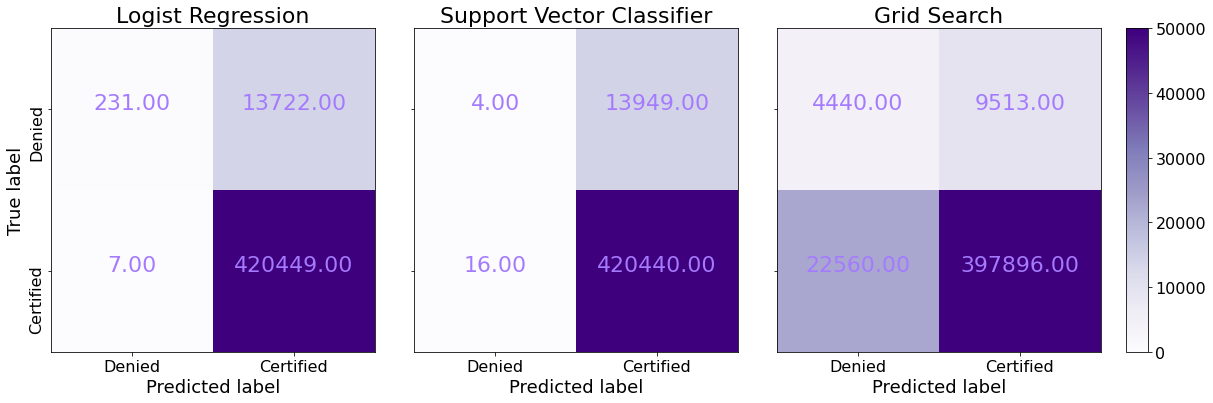

In [48]:
import itertools
from mpl_toolkits.axes_grid1 import ImageGrid


classes = ["Denied", "Certified"]

fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.55,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.35,
                 )
models_object_list = [lr_GS, SVC_GS, GB_GS]
clf_name_list = ["Logist Regression", "Support Vector Classifier", "Grid Search"]
for ax, clf, clf_name in zip(grid[:3], models_object_list, clf_name_list ):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    im = ax.imshow(cm, vmin=0, vmax=50_000, cmap='Purples')
    ax.set_title(clf_name, fontdict = {'fontsize' : 22})
    
    tick_marks = np.arange(2)
    ax.set_xticks(tick_marks)  # Warning: different signature for [x|y]ticks in pyplot and OO interface
    ax.set_xticklabels(classes, rotation=0, fontsize=16)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=90, fontsize=16)

    for j, k in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(k, j, format(cm[j, k], '.2f'),
                 horizontalalignment="center",
                 color="#A47AFE",
                 fontsize=22)

    ax.set_ylabel('True label', fontsize=18)
    ax.set_xlabel('Predicted label', fontsize=18)

# fig.delaxes(grid[7])
# fig.delaxes(grid[8])

fig.tight_layout()
fig.subplots_adjust(right=0.8)
fig.colorbar(im, cax=ax.cax)
ax.cax.tick_params(labelsize=16)

plt.show()

> Three chosen classical models were successfully tuned, albeit very little. The difficulty in fine-tuning these models are attributed to class-imbalanced in the dataset.